# Data Diri

*   Nama : Duwi Purnama Sidik
*   Email : duwi763@gmail.com
*   Alamat Domisili : Kota Malang, Jawa Timur






# Import Library

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from plotly import graph_objs as go

# Persiapan Data

## Upload Data

In [ ]:
uploaded = files.upload()

Saving AAPL_prices.csv to AAPL_prices.csv


In [ ]:
df = pd.read_csv('AAPL_prices.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600
...,...,...,...,...,...,...,...
10868,2024-01-24,195.419998,196.380005,194.339996,194.500000,194.500000,53631300
10869,2024-01-25,195.220001,196.270004,193.110001,194.169998,194.169998,54822100
10870,2024-01-26,194.270004,194.759995,191.940002,192.419998,192.419998,44594000
10871,2024-01-29,192.009995,192.199997,189.580002,191.729996,191.729996,47145600


In [ ]:
df = df.drop(columns=['High','Low','Close','Adj Close','Volume'])
df = df.rename(columns={'Open': 'Prize'})
df

,Date,Prize
0,1980-12-12,0.128348
1,1980-12-15,0.122210
2,1980-12-16,0.113281
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10868,2024-01-24,195.419998
10869,2024-01-25,195.220001
10870,2024-01-26,194.270004
10871,2024-01-29,192.009995


In [ ]:
df.isnull().sum()

Date     0
Prize    0
dtype: int64

# Visualisasi Data

Text(0, 0.5, 'Harga')

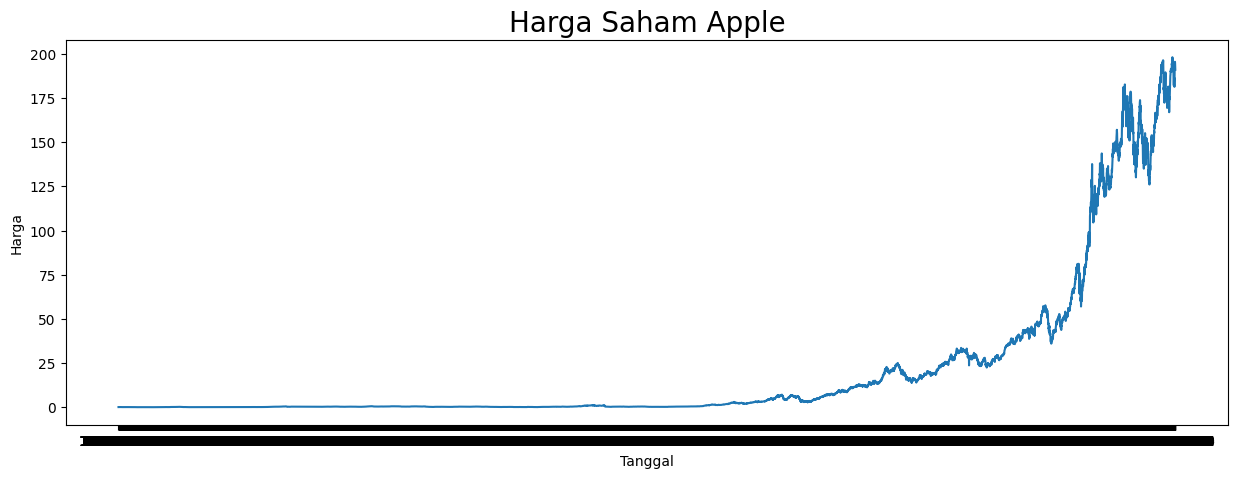

In [ ]:
prize = df['Prize'].values
dates = df['Date'].values
plt.figure(figsize=(15,5))
plt.plot(dates, prize)
plt.title('Harga Saham Apple', fontsize=20)
plt.xlabel('Tanggal')
plt.ylabel('Harga')

# Preprocessing Data

# Normalisasi Data


In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['Prize']= scaler.fit_transform(df['Prize'].values.reshape(-1,1))
df

,Date,Prize
0,1980-12-12,0.000397
1,1980-12-15,0.000366
2,1980-12-16,0.000321
3,1980-12-17,0.000333
4,1980-12-18,0.000350
...,...,...
10868,2024-01-24,0.986867
10869,2024-01-25,0.985856
10870,2024-01-26,0.981058
10871,2024-01-29,0.969642


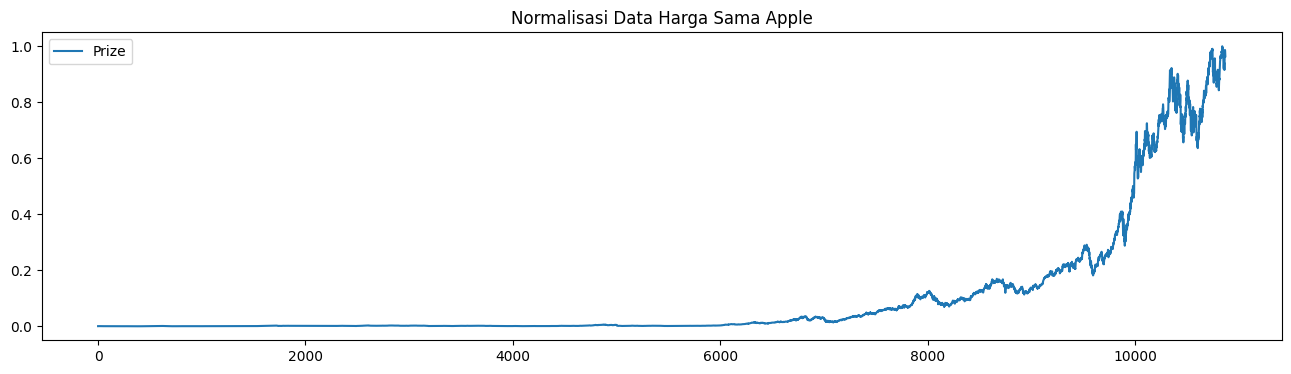

In [ ]:
df['Prize'].plot(figsize=(16,4),legend=True)
plt.title('Normalisasi Data Harga Sama Apple')
plt.show()

## Split Data

In [ ]:
dates = df['Date'].values
prize = df['Prize'].values

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(prize, dates, train_size=0.8, test_size=0.2, shuffle=False )

In [ ]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  8698
Total Data Validation :  2175


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=200, shuffle_buffer=1000)

# Modelling

In [ ]:
model = tf.keras.models.Sequential([
                                    Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    Bidirectional(tf.keras.layers.LSTM(60, dropout=0.2)),
                                    Dense(16, activation="relu"),
                                    Dropout(0.2),
                                    Dense(8, activation="relu"),
                                    Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
minMae = (df['Prize'].max() - df['Prize'].min()) * 10/100
print(minMae)

0.09999999999999998


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < minMae and logs.get('val_mae') < minMae):
      print("\MAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

# Training

In [ ]:
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[callbacks])

Epoch 1/100
44/44 [==============================] - 12s 102ms/step - loss: 6.9837e-04 - mae: 0.0172 - val_loss: 0.1389 - val_mae: 0.4439
Epoch 2/100
44/44 [==============================] - 2s 45ms/step - loss: 6.4594e-04 - mae: 0.0160 - val_loss: 0.1372 - val_mae: 0.4403
Epoch 3/100
44/44 [==============================] - 2s 47ms/step - loss: 6.1110e-04 - mae: 0.0164 - val_loss: 0.1358 - val_mae: 0.4371
Epoch 4/100
44/44 [==============================] - 2s 45ms/step - loss: 5.8101e-04 - mae: 0.0169 - val_loss: 0.1346 - val_mae: 0.4343
Epoch 5/100
44/44 [==============================] - 3s 72ms/step - loss: 5.5761e-04 - mae: 0.0174 - val_loss: 0.1334 - val_mae: 0.4317
Epoch 6/100
44/44 [==============================] - 2s 51ms/step - loss: 5.4130e-04 - mae: 0.0178 - val_loss: 0.1325 - val_mae: 0.4295
Epoch 7/100
44/44 [==============================] - 2s 45ms/step - loss: 5.2720e-04 - mae: 0.0182 - val_loss: 0.1316 - val_mae: 0.4275
Epoch 8/100
44/44 [===========================

# Evaluasi

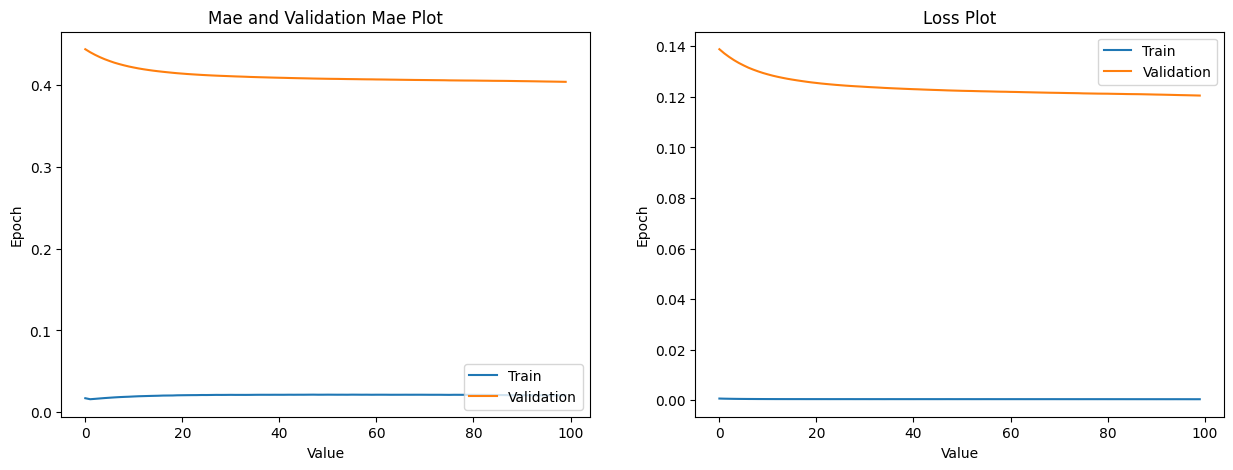

In [ ]:
figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mae and Validation Mae Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()